In [ ]:
#default_exp transparent

# Thinking transparent 

> No scattering makes life easier 



In [ ]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib notebook 

## Stratigraphic model 

In a typical situation we are confronted with a drawing or photograph and we do not have information about the palette of inks or the set of dyes that constitute the primaries. Also we do not know how these colorants are distributed. However, in order to simulate color change over time we need to create a stratigraphic model. 

We magically need to separate the optical properties of the colorants, and come up with a concentration or thickness map for each colorant layer.  

In [ ]:
import inktime

In [ ]:
K_CMY, primaries, RGB_img = kaleidoscope(bg_color='yellowish', return_layers=True) 

<IPython.core.display.Javascript object>


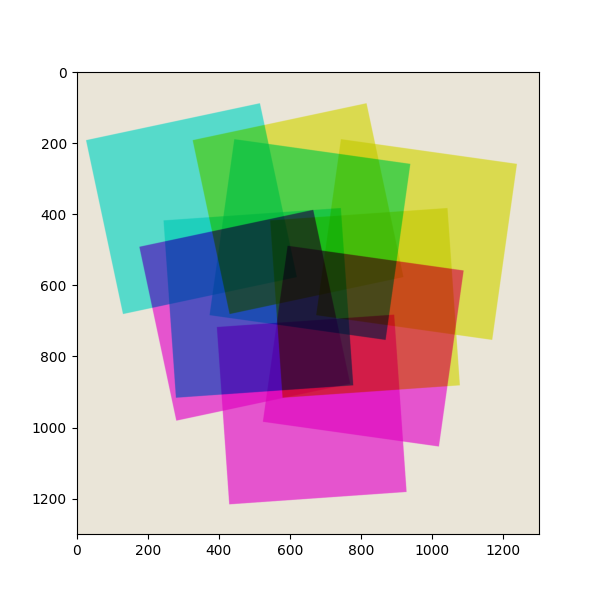

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(RGB_img)

In [ ]:
#export 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.transform as skt 

def transmission(D, K):    
    '''Calculate the RGB transmission of thickness map *D* and the RGB absorbance tuple *K*'''
    
    # convert possible list or tuple into numpy array 
    K = np.array(K)
    
    # prepare dimensions for broadcasting multiplication  
    D = D[:,:, None]    
    K = K[None, None, :]
    
    # multiply 
    optical_density = D * K 
    
    # Lambert-Beer 
    transmission = np.exp(-optical_density)
    
    return transmission


def kaleidoscope(K_CMY=None, bg_color='white', return_layers=False): 
    '''Create test image. '''
    
    # create foil stacks 
    
    foil_0 = np.zeros([1000, 1000])
    foil_0[100:600, 100:600] = 1
    foil_0 = skt.rotate(foil_0, 12)

    foil_1 = np.zeros([1000, 1000])
    foil_1[200:700, 400:900] = 1 
    foil_1 =  skt.rotate(foil_1, -8)

    foil_2 = np.zeros([1000, 1000])
    foil_2[400:900, 250:750] = 1 
    foil_2 =  skt.rotate(foil_2, 4)

    foil_stack = foil_0 + foil_1 + foil_2 
    
    # canvas 
    bg = np.zeros([1300, 1300])

    left_stack = bg.copy()
    left_stack[0:1000, 0:1000] = foil_stack 

    middle_stack = bg.copy()
    middle_stack[300:1300, 150:1150] = foil_stack 

    right_stack = bg.copy()
    right_stack[0:1000, 300:1300] = foil_stack 
    
    # colorize foil stacks 
    
    if K_CMY is None: 
        # default primaries 
        K_CMY = [[1, 0.05, 0.07], [0.02, 1, 0.05], [0.07, 0.05, 1]]
        
    K_cyan, K_magenta, K_yellow = K_CMY 

    T_cyan = transmission(left_stack, K_cyan)
    T_magenta = transmission(middle_stack, K_magenta)
    T_yellow = transmission(right_stack, K_yellow) 
    
    # create background    
  
    if bg_color is 'white': 
        bg_color = np.array([1, 1, 1])    
    elif bg_color is 'yellowish':  
        bg_color = np.array([0.92, 0.9, 0.85])    
    else: 
        bg_color = np.array(bg_color)

    Rg = np.ones([1300, 1300, 3]) * bg_color  
    
    # compose kaleidoscope image *R* by multiplying transmissions 
    
    RGB_img = Rg * T_cyan * T_magenta * T_yellow 
    
    if return_layers is False: 
        
        return RGB_img
    
    else: 
        
        return K_CMY, [Rg, T_cyan, T_magenta, T_yellow], RGB_img
 

In [ ]:
   
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[9, 3])
ax1.imshow(T_cyan)
ax1.set_title('cyan')

ax2.imshow(T_magenta)
ax2.set_title('magenta')

ax3.imshow(T_yellow)
ax3.set_title('yellow');

Now stack the three stacks. 

In [ ]:
# multiply transmissions 
T_CMY = T_cyan * T_magenta * T_yellow 

<IPython.core.display.Javascript object>


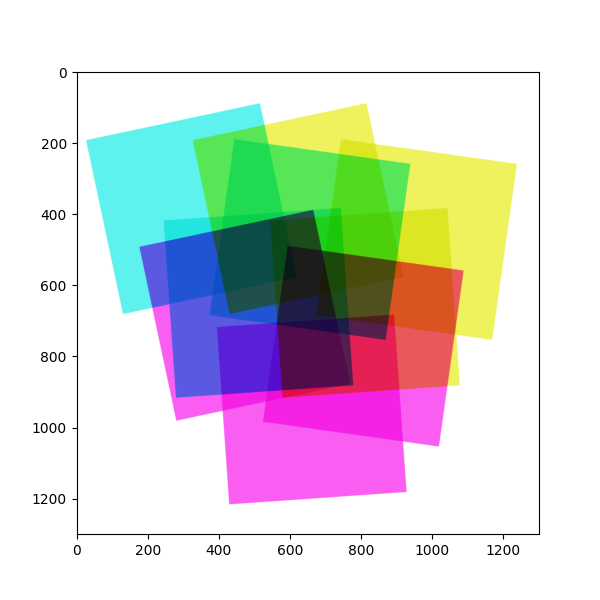

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(T_CMY);

It is easy to include an off white background. 

In [ ]:
paper = np.ones([1300, 1300, 3]) 
yellowish = np.array([0.92, 0.9, 0.85])

yellow_paper = paper * yellowish

<IPython.core.display.Javascript object>


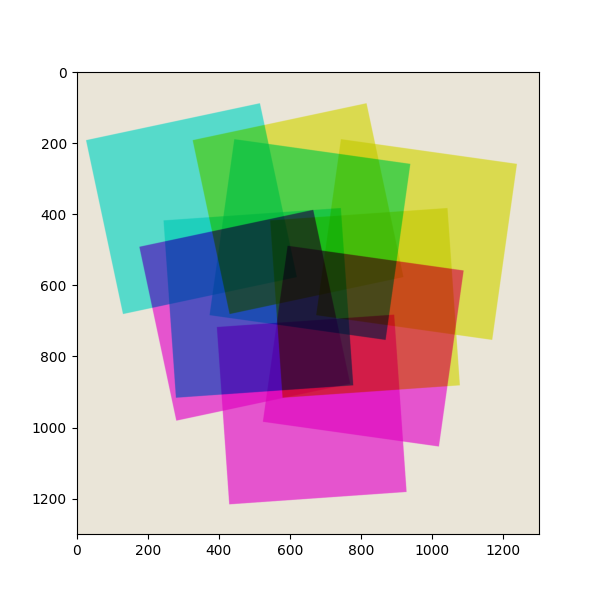

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(yellow_paper * T_CMY)

## Non-negative Matrix Factorization (NMF) 



See: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

As a first step we need to calculate the optical density for the three channels in the RGB image by taking the negative logarithm. 

In [ ]:
od_img = -np.log(T_CMY)
is_negative = od_img < 0
od_img[is_negative] = 0

In [ ]:
shape = od_img.shape

In [ ]:
X = od_img.reshape([-1, 3])

In [ ]:
import numpy as np
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF 

In [ ]:
#model = NMF(n_components=3, init='random', random_state=0, alpha_W=0.2, alpha_H=0.2, tol=0.000001, max_iter=3000)

#model = NMF(n_components=3, init='nndsvd', random_state=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)
#NMF(n_components=3, init='nndsvda', random_state=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)

# best before update with alpha=1
#model = NMF(n_components=3, init='nndsvd', random_state=0, alpha_W=1, alpha_H=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)

#not very good at all 
#model = NMF(n_components=3, init='random', random_state=0, alpha_W=0.2, alpha_H=0.2, tol=0.000001, max_iter=3000)

#model = NMF(n_components=3, init='nndsvd', l1_ratio=1.0, alpha=1, random_state=0, tol=0.001, max_iter=300)

# not so good as alpha=1
#model = NMF(n_components=3, init='nndsvd', alpha_W=1, alpha_H=0, random_state=0, tol=0.001, max_iter=300)

# not so good as alpha=1
#model = NMF(n_components=3, init='nndsvd', alpha_W=0.33, alpha_H=0, random_state=0, tol=0.001, max_iter=300)

#model = NMF(n_components=3, init='nndsvd', alpha=1, random_state=0, tol=0.001, max_iter=300)

#model = NMF(n_components=3, init='nndsvd', alpha_W=1, alpha_H=0, random_state=0, tol=0.001, 
#            max_iter=3000, regularization='transformation')

W = model.fit_transform(X)
H = model.components_

W_img = W.reshape(shape)

/home/frank/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/home/frank/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
model.n_iter_

3000

<IPython.core.display.Javascript object>


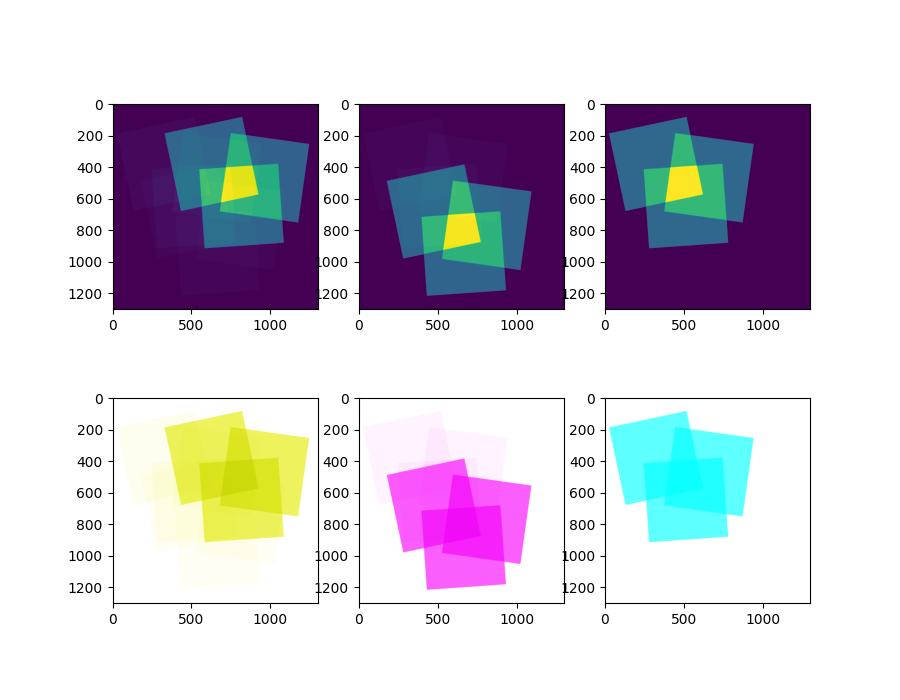

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[9, 7])

axs[0, 0].imshow(W_img[:,:,0])
axs[0, 1].imshow(W_img[:,:,1])
axs[0, 2].imshow(W_img[:,:,2])

axs[1, 0].imshow(transmission(W_img[:,:,0], H[0]))
axs[1, 1].imshow(transmission(W_img[:,:,1], H[1]))
axs[1, 2].imshow(transmission(W_img[:,:,2], H[2]))

In [ ]:
T_CMY_fit = transmission(W_img[:,:,0], H[0]) * transmission(W_img[:,:,1], H[1]) * transmission(W_img[:,:,2], H[2])

<IPython.core.display.Javascript object>


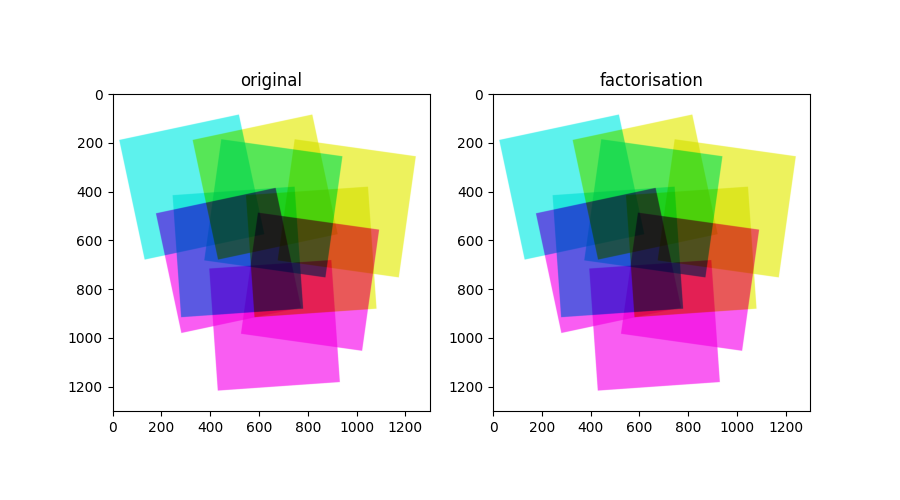

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[9, 5])

ax.imshow(T_CMY)
ax.set_title('original')
ax1.imshow(T_CMY_fit)
ax1.set_title('factorisation');